# Testing Different Weight Initialization Algorithms

In this notebook, I test different ways to initialize weights. To be honest, I was not able to find that they had much impact on the final results. One additional method I could use in the future is initializing the weights as smooth noise, using Perlin's algorithm or something similar.

## Load Data

In [1]:
from typing import *
import numpy as np
from matplotlib import pyplot as plt
from data_loader import load_data

np.set_printoptions(suppress=True, precision=2)
np.random.seed(101010)

In [2]:
# Could take 10 to 20 seconds
train_images, train_labels, test_images, test_labels = load_data()

# flatten and collect data
training_data = [(x.flatten(), y) for x, y in zip(train_images, train_labels)]
testing_data = [(x.flatten(), y) for x, y in zip(test_images, test_labels)]

## Weight Initialization Algorithms

### Centralized weights

In [5]:
def scaled(
        input_dims: Tuple[int, int],
        output_size: int
) -> np.ndarray:
    x, y = input_dims
    mid_x, mid_y = x / 2, y / 2
    input_size = x * y
    weights = np.random.randn(output_size, *input_dims)
    weights /= np.sqrt(input_size)

    half_x = mid_x / 2
    half_y = mid_y / 2

    for i in range(x):
        for j in range(y):
            x_dist = abs(i - mid_x)
            y_dist = abs(j - mid_y)
            if x_dist > y_dist:
                if x_dist > half_x:
                    weights[:, i, j] *= (2 - x_dist / half_x)
            else:
                if y_dist > half_y:
                    weights[:, i, j] *= (2 - y_dist / half_y)

    return weights

def subtracted(
        input_dims: Tuple[int, int],
        output_size: int
) -> np.ndarray:
    x, y = input_dims
    mid_x, mid_y = x / 2, y / 2
    min_mid = min(mid_x, mid_y) * 4 / 5
    input_size = x * y
    weights = np.random.randn(output_size, *input_dims)
    weights /= np.sqrt(input_size)

    for i in range(x):
        for j in range(y):
            dist = np.sqrt((i - mid_x) ** 2 + (j - mid_y) ** 2)
            if dist > min_mid:
                weights[:, i, j] = 0

    return weights

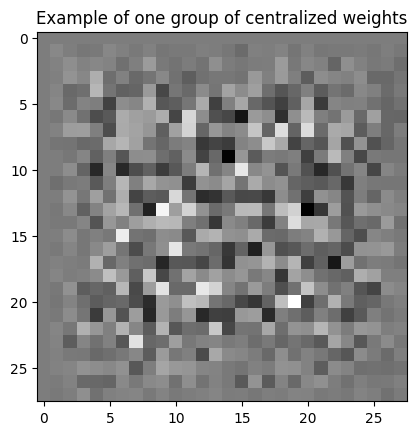

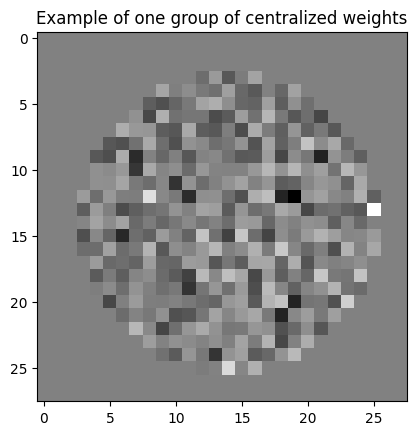

In [6]:
scaled_weights = scaled((28, 28), 30)
subtracted_weights = subtracted((28, 28), 30)
plt.imshow(scaled_weights[0], interpolation="nearest", cmap='gray')
plt.title("Example of one group of centralized weights")
plt.show()
plt.imshow(subtracted_weights[0], interpolation="nearest", cmap='gray')
plt.title("Example of one group of centralized weights")
plt.show()

### Compare network performances

In [7]:
from network import *
from layers import *
from loss import *

In [8]:
layers = [
    Dense(784, 30),
    ReLU(30),
    Dense(30, 10),
    ReLU(10),
    Softmax(10)
]
standard_network = Network(layers, 0.1, 10)

In [9]:
layers = [
    Dense(784, 30, weights=scaled_weights.reshape(30, 784)),
    ReLU(30),
    Dense(30, 10),
    ReLU(10),
    Softmax(10)
]
scaled_network = Network(layers, 0.1, 10)

In [10]:
layers = [
    Dense(784, 30, weights=subtracted_weights.reshape(30, 784), regularization_parameter=0.1),
    LeakyReLU(30, 0.1),
    Dense(30, 10, regularization_parameter=0.1),
    LeakyReLU(10, 0.1),
    Softmax(10)
]
subtracted_network = Network(layers, 0.1, 10)

In [11]:
standard_network.set_training(True)
scaled_network.set_training(True)
subtracted_network.set_training(True)

c1 = c2 = c3 = 0

runs = 10
for i in range(runs):
    standard_network.reset()
    scaled_network.reset()
    subtracted_network.reset()

    standard_network.train(1, training_data, NLL(), suppress=True)
    correct = standard_network.evaluate(testing_data)
    p1 = round(correct / 100, 1)
    c1 += correct

    scaled_network.train(1, training_data, NLL(), suppress=True)
    correct = scaled_network.evaluate(testing_data)
    p2 = round(correct / 100, 1)
    c2 += correct
    
    subtracted_network.train(1, training_data, NLL(), suppress=True)
    correct = subtracted_network.evaluate(testing_data)
    p3 = round(correct / 100, 1)
    c3 += correct

    print(f"Run {i+1} standard, scaled, subtracted scores: {p1}, {p2}, {p3}")

total = len(testing_data) * runs
p1 = round(c1 / total * 100, 1)
p2 = round(c2 / total * 100, 1)
p3 = round(c3 / total * 100, 1)
print(f"Standard initialization: {c1} / {total} ({p1}%)")
print(f"Scaled initialization: {c2} / {total} ({p2}%)")
print(f"Subtracted initialization: {c3} / {total} ({p3}%)")

KeyboardInterrupt: 

### Plot weights

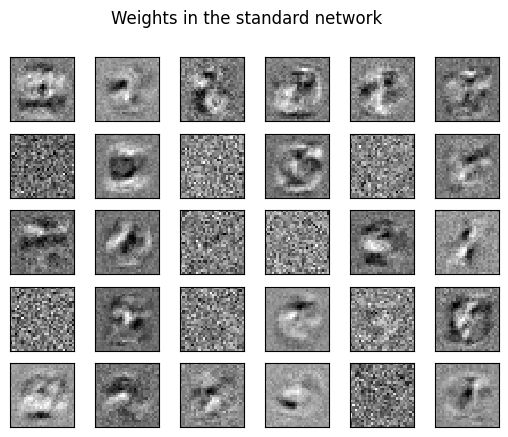

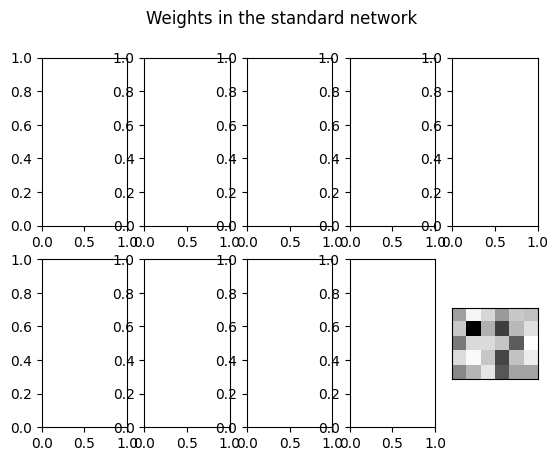

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the standard network")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = standard_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

fig, axes = plt.subplots(2, 5)
fig.suptitle("Weights in the standard network")
res = np.zeros((5, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    res += standard_network.layers[2].weights[i].reshape(5, 6)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.imshow(res, interpolation="nearest", cmap="gray")

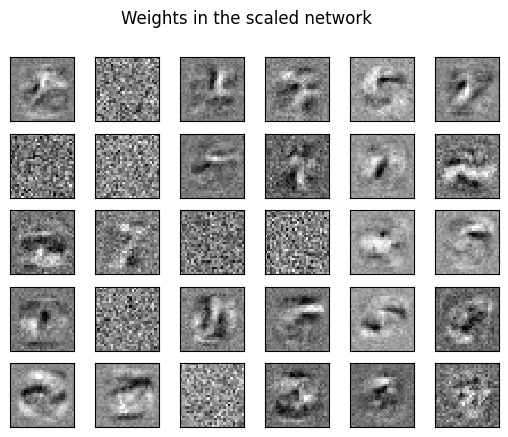

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the scaled network")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = scaled_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

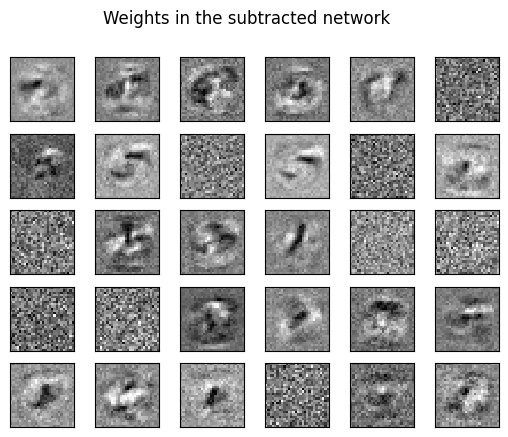

In [ ]:
fig, axes = plt.subplots(5, 6)
fig.suptitle("Weights in the subtracted network")
for i in range(30):
    ax = axes[i // 6, i % 6]
    im = subtracted_network.layers[0].weights[i].reshape(28, 28)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(im, interpolation="nearest", cmap="gray")

### Test the Network on My Handwriting

The following code uses images of digits I wrote myself, and tests the model's performance on these digits.